# Bayesian Belief Network - Weather Forecasting

Dane dotyczące pogody w Australii zostały pobrane z https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [ ]:
!pip install pybbn

In [ ]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.graph.jointree import JoinTree
from pybbn.graph.potential import Potential

In [ ]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustSpeedCat,Humidity9amCat,Humidity3pmCat
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,1.40-50,1.>60,0.<=60
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,1.40-50,0.<=60,0.<=60
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,1.40-50,0.<=60,0.<=60
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,0.<=40,0.<=60,0.<=60
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,1.40-50,1.>60,0.<=60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No,0.<=40,0.<=60,0.<=60
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No,0.<=40,0.<=60,0.<=60
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No,0.<=40,0.<=60,0.<=60
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No,0.<=40,0.<=60,0.<=60


In [ ]:
test_count = 10000
df_sorted = df.sort_values(by='Date')
df_train = df_sorted.iloc[:-test_count-1,:]
df_test = df_sorted.iloc[-test_count:,:]

In [ ]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [ ]:
# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df_train, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df_train, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df_train, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df_train, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))


In [ ]:
# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

In [ ]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

NameError: ignored

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67008
1=>60|0.32992
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30761
0=>60|0.69239
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58409
2=40-50|0.24072
2=>50|0.17519
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77517
3=Yes|0.22483
----------------


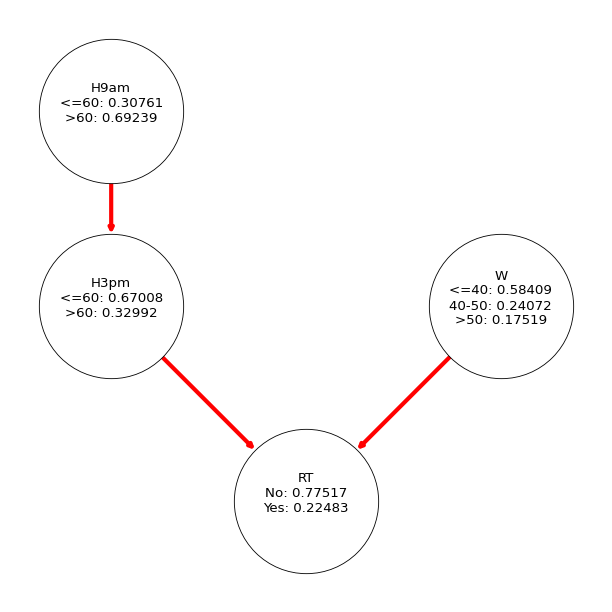

In [ ]:
# Define a function for printing marginal probabilities
def print_probs(jt):
    for node in jt.get_bbn_nodes():
        potential = jt.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

def node_to_text(node, potential):
  node_dict = node.to_dict()
  potential_dict = list(Potential.to_dict([potential]).values())
  text = node_dict['variable']['name'] + "\n"

  for i in range(len(node_dict['variable']['values'])):
    text += f"{node_dict['variable']['values'][i]}: {potential_dict[i]:.5f}\n"
  return text

def draw_graph_probs(jt):
  d_new = {0: 'H9am\n<=60:   \n>60:    ', 1: 'H3pm', 2: 'W', 3: 'RT'}
  options2 = {
      "font_size": 16,
      "node_size": 30000,
      "node_color": "white",
      "edgecolors": "black",
      "edge_color": "red",
      "linewidths": 1,
      "width": 5,
      "node_shape": "o",}
  plt.figure(1, figsize=(10, 10), dpi=60)
  for node in jt.get_bbn_nodes():
    node_dict = node.to_dict()
    potential = jt.get_bbn_potential(node)
    d_new[node_dict['variable']['id']] = node_to_text(node, potential)

  nx.draw(n, with_labels=True, labels=d_new, pos=pos, **options2)
  ax = plt.gca()
  ax.margins(0.20)
  plt.axis("off")
  plt.show()

# Use the above function to print marginal probabilities
print_probs(join_tree)
draw_graph_probs(join_tree)

In [ ]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(jt, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(jt.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    jt.set_observation(ev)
    

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.55575
1=>60|0.44425
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58409
2=40-50|0.24072
2=>50|0.17519
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.73624
3=Yes|0.26376
----------------


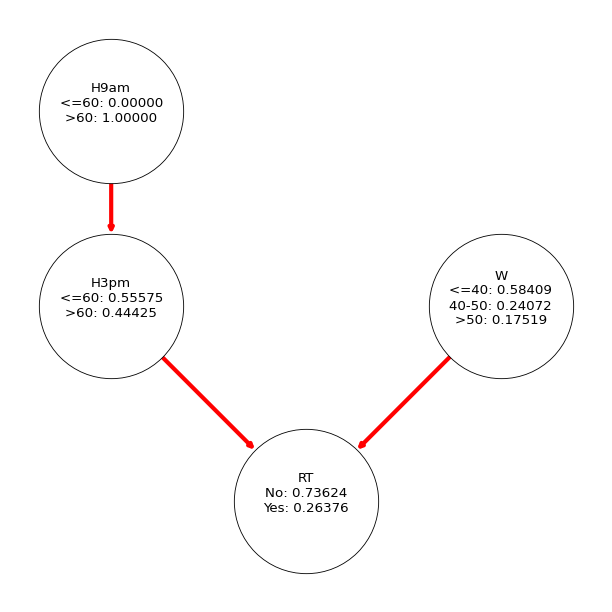

In [ ]:
join_tree = InferenceController.apply(bbn)

# Use above function to add evidence
evidence(join_tree, 'H9am', '>60', 1.0)

# Print marginal probabilities
print_probs(join_tree)
draw_graph_probs(join_tree)

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.06766
0=>60|0.93234
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.31991
3=Yes|0.68009
----------------


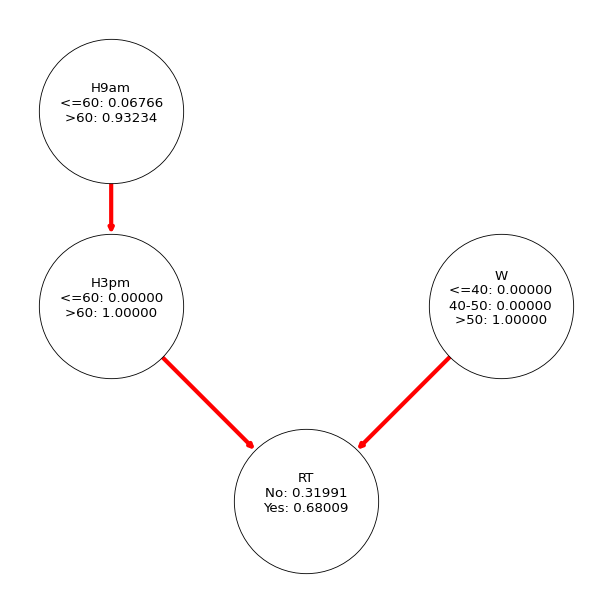

In [ ]:
jt2 = InferenceController.apply(bbn)

# Add more evidence
evidence(jt2, 'H3pm', '>60', 1.0)
evidence(jt2, 'W', '>50', 1.0)
# Print marginal probabilities
print_probs(jt2)
draw_graph_probs(jt2)

In [ ]:
def test_prediction_for_one_item(bbn, df_item):
  jt = InferenceController.apply(bbn)

  H9am_value = df_item['Humidity3pmCat'].split('.')[1]
  W_value = df_item['WindGustSpeedCat'].split('.')[1]

  evidence(jt, 'H3pm', H9am_value, 1.0)
  evidence(jt, 'W', W_value, 1.0)

  pred_dict = list(Potential.to_dict([jt.get_bbn_potential(jt.get_bbn_node_by_name('RT'))]).values())
  pred = "Yes" if pred_dict[1] >= 0.5 else "No"

  real_value = df_item['RainTomorrow']

  return (pred==real_value), pred_dict, pred, real_value

In [ ]:
def test_bbn_with_dataframe(bbn, df):
  test_count = df.shape[0]

  test_vals = []
  pred_vals = []

  correct_cnt = 0

  for i in range(test_count):
    df_item = df.iloc[i]
    isCorrect, probabilities, pred, real_value = test_prediction_for_one_item(bbn, df_item)
    correct_cnt += 1 if isCorrect else 0
    test_vals.append(real_value)
    pred_vals.append(pred)
  
  return (correct_cnt/test_count), correct_cnt, test_count, test_vals, pred_vals

In [ ]:
accuracy, correct_cnt, test_count, test_vals, pred_vals = test_bbn_with_dataframe(bbn, df_test)
print(f"Accuracy: {accuracy}")
print(f"Correct count: {correct_cnt}, All count: {test_count}")

Accuracy: 0.8079
Correct count: 8079, All count: 10000
